In [2]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow, Circle
import numpy as np

# Constants
#colors = [{1:'black', -1:'gray'},{1:'darkred', -1:'pink'}]
colors = {0:'black', 1:'gray', 2: 'blue', -1:'pink', -2:'darkred'}

In [3]:
# Class Definitions
class Marker:
    def __init__(self, type : int, subtype : int, time : int, value : int):
        self.type = type
        self.subtype = subtype
        self.time = time
        self.value = value

# Class Definitions
class PulseBound:
    def __init__(self, start : (int,float), end : (int,float)):
        self.start = start
        self.end = end

# Class Definitions
class PulsePeakBound(PulseBound):
    def __init__(self, start : (int,float), end : (int,float), peak : (int,float)):
        super().__init__(start,end)
        self.peak = peak
        
    def add_to_axis(self,ax):
        x = self.start[0]
        y = self.start[1]
        x_to_peak = self.end[0] - x
        y_to_peak = self.end[1] - y
        arrow = Arrow(x,y,x_to_peak,y_to_peak, edgecolor = "gray", width = 0.00001, linestyle = "dashed")
        ax.add_patch(arrow)

        arrow = Arrow(self.start[0], self.peak[1], self.end[0] - self.start[0], 0, edgecolor = "red", width = 0.00001)
        #ax.add_patch(arrow)

# Class Definitions
class PulseBasic(PulsePeakBound):
    def __init__(self, start : (int,float), end : (int,float), peak : (int,float), steepest_rise : (int,float,float), sharpest_drop : (int,float,float)):
        super().__init__(start,end,peak)
        
        self.steepest_rise = steepest_rise
        self.sharpest_drop = sharpest_drop
    
    def add_to_axis(self,ax):
        super().add_to_axis(ax)
        gradient = (self.end[1] - self.start[1])/(self.end[0] - self.start[0])
        x = self.steepest_rise[0]
        y = self.steepest_rise[1] - self.start[1] - gradient*(self.steepest_rise[0] - self.start[0])
        #width = self.sharpest_drop[0] - self.steepest_rise[0]
        #height = self.sharpest_drop[1] - self.steepest_rise[1]
        arrow = Circle((x,y), 3, edgecolor = "black", facecolor = "gray", hatch = "|")
        #ax.add_patch(arrow)

    def plot(self, ax, trace):
        gradient = (self.end[1] - self.start[1])/(self.end[0] - self.start[0])
        x = np.array([point for point in trace[0] if self.start[0] <= point <= self.end[0]])
        y = np.array([(point[1] - self.start[1]) - gradient*(point[0] - self.start[0])
            for point in zip(trace[0],trace[1])
            if self.start[0] <= point[0] <= self.end[0]
        ])
        ax.plot(x, y, color = "green")
        

In [4]:
# Basic Plots
def plot_markers(markers : [Marker], J):
    plt.vlines([marker.time for marker in markers],J[0]/2 + 10,J[1]/2 - 10, colors = [colors[marker.type] for marker in markers])

def plot_bounds(bounds : [PulseBound],J):
    datum = datum[1:]
    start, end = datum[0], datum[1]
    plt.plot()
    plt.vlines([start,end],J[0]/2 + 10,J[1]/2 - 10, colors = ['red', 'black'])
    plt.hlines(J[0]/4 + J[1]/4, start, end)

In [5]:

def plot_gaussian(datum):
    mu = datum[0]
    A = datum[1]
    sigma = datum[2]
    x = np.arange(mu - 100, mu + 100, 0.1)
    y = A*np.exp(-0.5*np.square(x - mu)/(sigma*sigma))
    plt.plot(x, y, linestyle = "dashed")

def plot_biexp_curve(t, kappa, rho):
    return np.exp(-t/kappa) - np.exp(-t/rho)

def plot_biexp(datum):
    datum = datum[1:]
    
    start, end = datum[0], datum[1]
    baseline, amp, kappa, rho = datum[2], datum[3], datum[4], datum[5]
    x = np.arange(start, end, 0.1)
    y = amp*plot_biexp_curve(x - start, kappa, rho) + baseline
    plt.plot(x, y, linestyle = "dashed")

def plot_second_order_cpx(x, A,B,C, param_lambda, param_theta):
    return np.exp(-x*param_lambda)*(A*np.cos(0.5*x*param_theta) + B*np.sin(0.5*x*param_theta)) + C

def plot_second_order(datum):
    datum = datum[1:]
    start, end, _ = datum[0], datum[1], datum[2]
    param_lambda, param_theta = datum[3], datum[4]
    A,B,C = datum[5], datum[6], datum[7]
    x = np.arange(start, end, 0.1)
    y = plot_second_order_cpx(x - start, A, B, C, param_lambda, param_theta)
    plt.plot(x,y, linestyle = "dashed")

In [6]:


# f = open('data/retrace.csv')
# tokens = [e.split(",") for e in f.readlines()]
# x = [int(e[0]) for e in tokens]
# y = [int(e[1]) for e in tokens]
# handle = plt.plot(x,y)

TIME_UNIT = 1.5378937007874016e-2

def get_trace_file(filename):
    f = open("../" + filename, 'r')
    tokens = [[float(x) for x in e.split(",")] for e in f.readlines()]
    #tokens = [token for token in tokens if I[0] <= token[0] <= I[1]]
    #maxy = max([e[1] for e in tokens])
    x = [e[0] for e in tokens]
    y = [e[1]*TIME_UNIT for e in tokens]
    return (x,y)

def get_detect_file(filename):
    f = open("../" + filename, 'r')
    tokens = [[float(x) for x in e.split(",")] for e in f.readlines()]
    markers = [Marker(int(token[1]),0,int(token[0]),int(token[2])) for token in tokens]
    return markers

def get_event_file(filename):
    f = open("../" + filename, 'r')
    tokens = [[float(x) for x in e.split(",")] for e in f.readlines()]
    return tokens

In [7]:
def FileToPulseBasics(data : [[float]]) -> [PulseBasic]:
    return [
        PulseBasic(
            (datum[0],datum[1]*TIME_UNIT),
            (datum[2],datum[3]*TIME_UNIT),
            (datum[4],datum[5]*TIME_UNIT),
            (datum[6],datum[7]*TIME_UNIT,datum[8]),
            (datum[9],datum[10]*TIME_UNIT,datum[11])
        ) for datum in data
    ]

In [8]:
def create_trace_plot(ax,data,I,J):
    #plt.subplot(ax)
    plt.xlim(I)
    #plt.ylim(J)
    plt.plot(data[0],data[1])

def create_event_plot(ax,data,I,J):
    #plt.subplot(ax)
    #plt.xlim(I)
    #plt.ylim(J)
    plt.subplot(ax)
    for datum in data:
        plot_bounds(datum,J)
        plot_second_order(datum)

def create_basic_plot(ax,data,trace,I,J):
    #plt.subplot(ax)
    plt.xlim(I)
    plt.ylim(J)
    #plt.subplot(ax)
    for basic in FileToPulseBasics(data):
        basic.plot(ax,trace)
        basic.add_to_axis(ax)

In [9]:

def create_plot(data, I):
    fig = plt.figure(figsize = (14,12))
    ax = plt.subplot(2,1,1)
    ax.patches.clear()
    maxy = max(data[0][1])
    miny = max(0,min(data[0][1]))
    J = (miny,maxy)
    create_trace_plot(ax,data[0],I,J)
    ax.scatter([d[0] for d in data[1]], [(J[0] + J[1])/2]*len(data[1]))
    #create_trace_plot(ax,data[1],I,J)
    #create_basic_plot(ax,data[2],data[1],I,J)
    ax.legend(['Raw Trace'])#, 'Lopass Trace', 'Pulse Trace (baseline adjusted)'])
    ax.set_xlabel("Sample (0.8ns)")
    ax.set_ylabel("Intensity (mV)")

    return fig,ax

In [29]:
from ipywidgets import interact, widgets
index = 0
data = [get_trace_file(f'output/Saves/myoutputf5c0_raw.csv'),
        get_event_file(f'output/Saves/myoutputf2c0_pulses.csv')]

def func(delta, size):
    I = (delta,delta + size)
    fig,ax = create_plot(data,I)

interact(func,
    delta = widgets.IntSlider(min=0, max=30000, step=100, value=0),
    size = widgets.IntSlider(min=100, max=30000, step=100, value=30000)
)

interactive(children=(IntSlider(value=0, description='delta', max=30000, step=100), IntSlider(value=30000, des…

<function __main__.func(delta, size)>

In [ ]:
times = [pulse.peak[1]
            for pulse in FileToPulseBasics(get_event_file('Saves/output_all_pulses.csv'))
                if pulse.peak[1] > 0.395
        ]
values, edges, _, = plt.hist(times, bins = 20, density = True, log = True)


FileNotFoundError: [Errno 2] No such file or directory: '../Saves/output_all_pulses.csv'

[[2.18598806e-09 1.81511112e-10]
 [1.81511112e-10 1.58385584e-11]]
[0.00173971 0.00032909]
65952
2.4309336872491787e-06


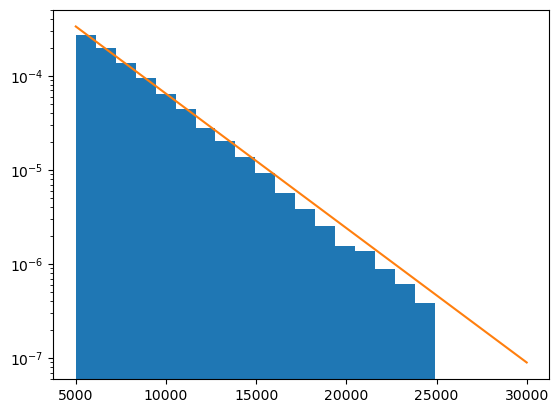

In [ ]:
times = [pulse.steepest_rise[0]
            for pulse in FileToPulseBasics(get_event_file('Saves/output_all_pulses.csv'))
                if pulse.start[0] > 5000
                and pulse.end[0] < 25000
                and pulse.peak[1] > 0.3980
        ]
values, edges, _, = plt.hist(times, bins = 18, density = True, log = True)

from scipy.optimize import curve_fit
def func(x, a, b):
    return a*np.exp(-b*x)

pos = np.array([(e1 + e2)/2 for (e1,e2) in zip(edges[:-1],edges[1:])])

popt, pcov = curve_fit(func, pos, values, p0 = (1.0,0.0))
print(pcov)
print(popt)
print(len(times))
print(8e-10/popt[1])

X = np.linspace(5000,30000)
plt.plot(X,func(X, *popt))

[[5.26590663e-10 3.18104624e-11]
 [3.18104624e-11 1.99703936e-12]]
[0.00247022 0.00037492]
171450
2.1338164045163344e-06


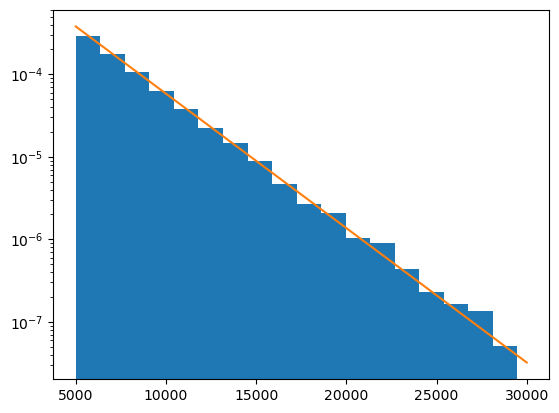

In [ ]:
times = [pulse.start[0]
            for pulse in FileToPulseBasics(get_event_file('Saves/output_all_pulses_simple.csv'))
                if pulse.start[0] > 5000
        ]
values, edges, _, = plt.hist(times, bins = 18, density = True, log = True)

from scipy.optimize import curve_fit
def func(x, a, b):
    return a*np.exp(-b*x)

pos = np.array([(e1 + e2)/2 for (e1,e2) in zip(edges[:-1],edges[1:])])

popt, pcov = curve_fit(func, pos, values, p0 = (1.0,0.0))
print(pcov)
print(popt)
print(len(times))
print(8e-10/popt[1])

X = np.linspace(5000,30000)
plt.plot(X,func(X, *popt))